In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import emd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')

In [3]:
# take only the 50% of the data
df = df[:int(len(df)//2)]

In [4]:
target_column = 'T (degC)'
target_index = 'datetime'
load = df[target_column]
time = df[target_index]
x_label = 'Time'
y_label = 'Temperature (°C)'

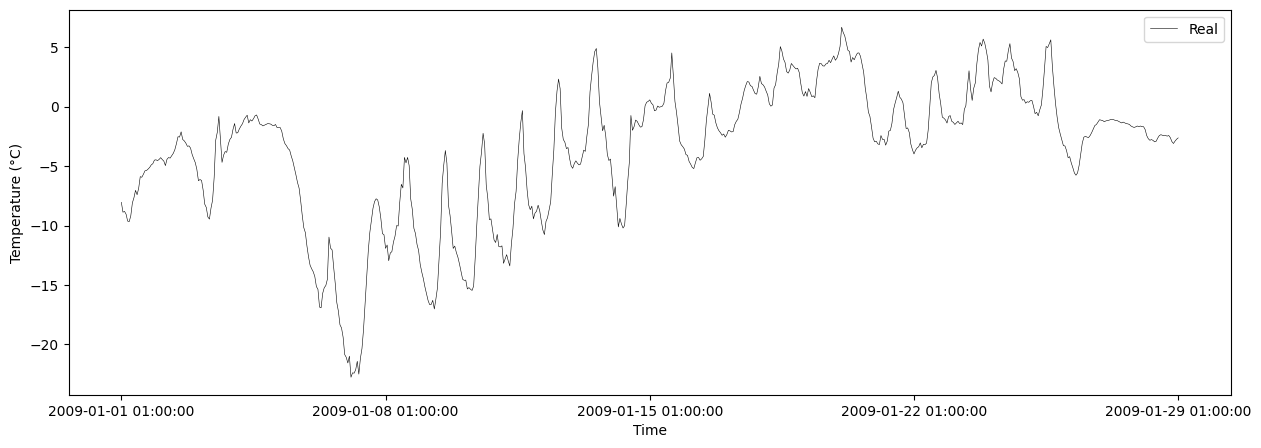

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(time[:673], load[:673], color='k', label='Real', linewidth=0.4)
plt.xticks(np.arange(0, 673, step=168))
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

In [6]:
train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

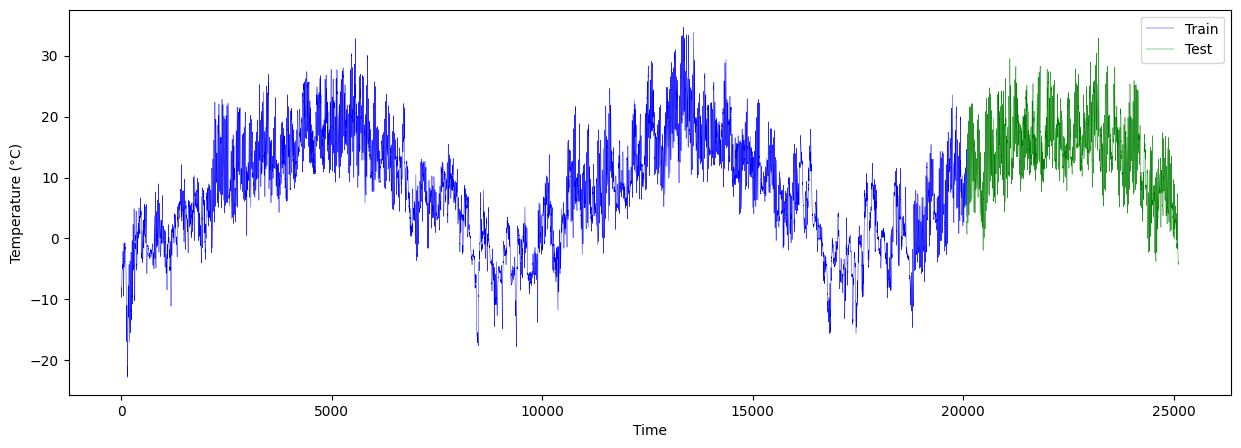

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(train, label='Train', color='b', linewidth=0.3)
plt.plot(test, label='Test', color='g', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

In [8]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)

for i in range(1, 4):
    df_train["lag{}".format(i)] = df_train[target_column].shift(i)
    df_test["lag{}".format(i)] = df_test[target_column].shift(i)

df_train = df_train.bfill().drop(columns=[target_column])
df_test = df_test.bfill().drop(columns=[target_column])

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,-4.014279,-2.111880,-0.730038,-1.781659,3.404784,2.434745,-1.398375,-3.911784,-10.911866,4.635883
1,4.097256,0.802898,-0.734009,-1.657708,3.423503,2.450910,-1.410105,-3.906512,-10.908001,4.635787
2,-4.146000,4.529245,-0.453035,-1.506201,3.443808,2.466653,-1.421701,-3.901180,-10.904129,4.635692
3,3.030510,5.717373,-0.021706,-1.332181,3.465652,2.481966,-1.433159,-3.895788,-10.900250,4.635597
4,-6.823770,3.612801,0.405531,-1.140605,3.488983,2.496841,-1.444481,-3.890334,-10.896365,4.635502
...,...,...,...,...,...,...,...,...,...,...
20084,6.070331,1.443510,-0.204559,-0.153994,3.879720,-1.871714,-0.401879,1.577586,5.793130,1.359059
20085,-7.270918,1.476625,-0.496547,0.014156,3.885815,-1.867888,-0.401229,1.573739,5.792295,1.358918
20086,6.816113,0.819472,-0.683914,0.167145,3.887888,-1.864042,-0.400399,1.569884,5.791449,1.358778
20087,2.435733,-0.218158,-0.792626,0.301338,3.885912,-1.860178,-0.399391,1.566022,5.790592,1.358639


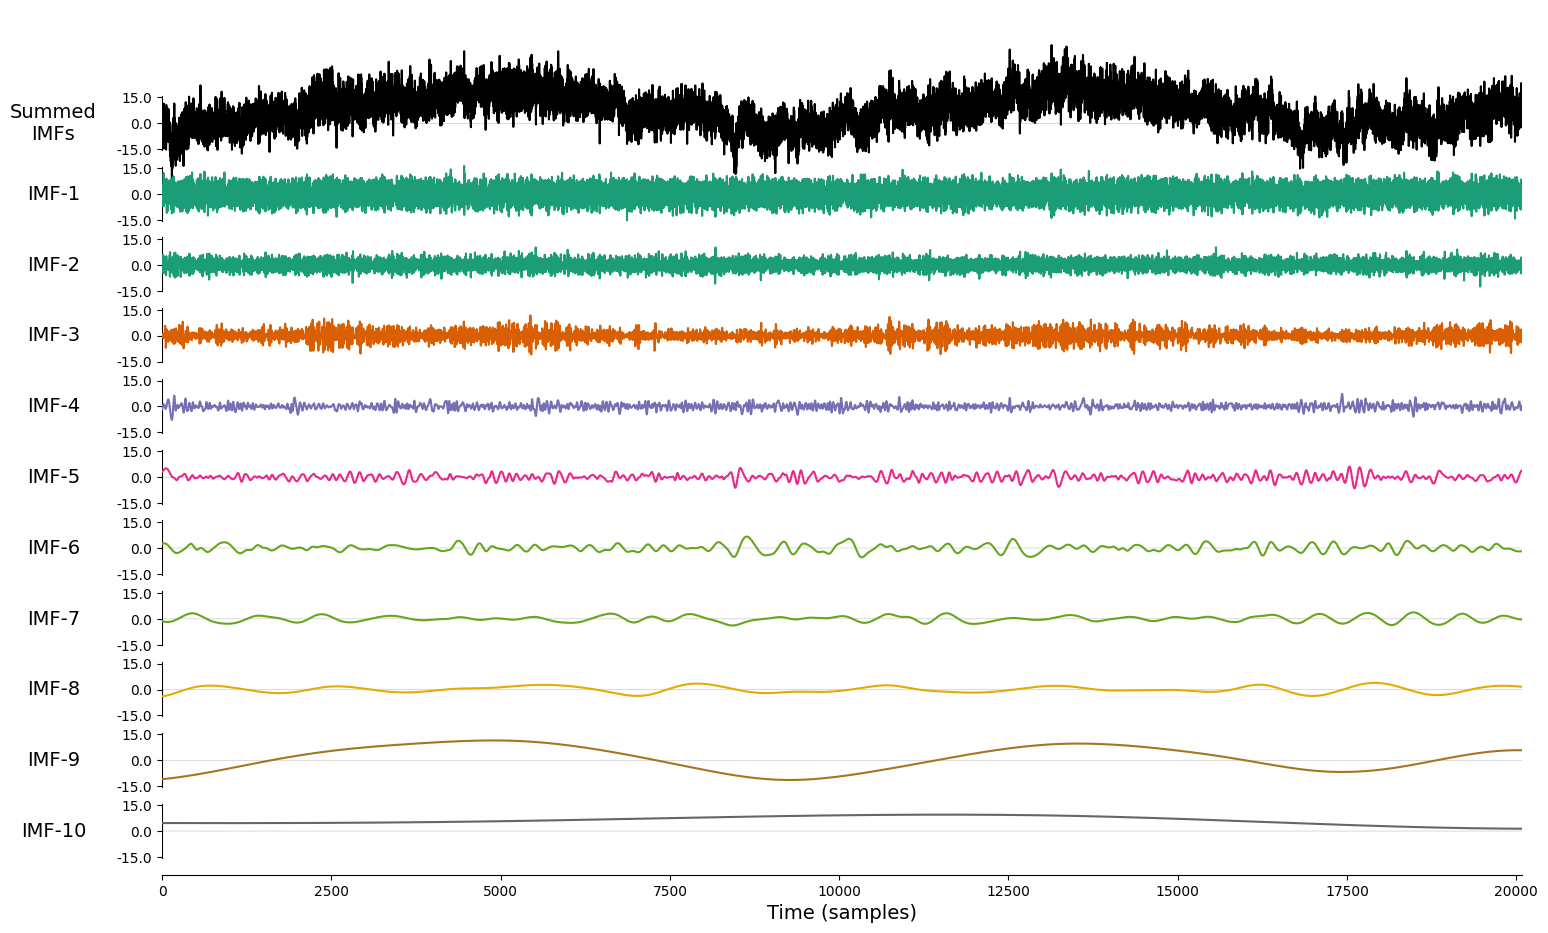

In [9]:
# EEMD
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)
imf_eemd_df = pd.DataFrame(data=imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i + 1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

In [10]:
# Normalización y preparación de datos para LSTM
def prepare_data(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(1, len(scaled_data)):
        X.append(scaled_data[i-1:i, 0])
        y.append(scaled_data[i, 0])
        
    return np.array(X), np.array(y), scaler

In [11]:
# Parámetros del modelo
c = 10
d = 1
epochs = 8
test_length = len(test)
verbose = 0

In [12]:
# Entrenamiento de modelos LSTM para IMFs 1 al 7
# IMF 1
imf1_eemd_lstm_X, imf1_eemd_lstm_y, scaler1 = prepare_data(imf_eemd_df['imf_eemd_1'])
imf1_eemd_lstm_X = imf1_eemd_lstm_X.reshape((imf1_eemd_lstm_X.shape[0], 1, imf1_eemd_lstm_X.shape[1]))

model1 = Sequential()
model1.add(LSTM(c, activation='relu', input_shape=(imf1_eemd_lstm_X.shape[1], imf1_eemd_lstm_X.shape[2])))
model1.add(Dense(d))
model1.compile(optimizer='adam', loss='mse')
model1.fit(imf1_eemd_lstm_X, imf1_eemd_lstm_y, epochs=epochs, verbose=verbose)
imf1_eemd_lstm_fc = model1.predict(imf1_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf1_eemd_lstm_fc = scaler1.inverse_transform(imf1_eemd_lstm_fc)

# IMF 2
imf2_eemd_lstm_X, imf2_eemd_lstm_y, scaler2 = prepare_data(imf_eemd_df['imf_eemd_2'])
imf2_eemd_lstm_X = imf2_eemd_lstm_X.reshape((imf2_eemd_lstm_X.shape[0], 1, imf2_eemd_lstm_X.shape[1]))

model2 = Sequential()
model2.add(LSTM(c, activation='relu', input_shape=(imf2_eemd_lstm_X.shape[1], imf2_eemd_lstm_X.shape[2])))
model2.add(Dense(d))
model2.compile(optimizer='adam', loss='mse')
model2.fit(imf2_eemd_lstm_X, imf2_eemd_lstm_y, epochs=epochs, verbose=verbose)
imf2_eemd_lstm_fc = model2.predict(imf2_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf2_eemd_lstm_fc = scaler2.inverse_transform(imf2_eemd_lstm_fc)

# IMF 3
imf3_eemd_lstm_X, imf3_eemd_lstm_y, scaler3 = prepare_data(imf_eemd_df['imf_eemd_3'])
imf3_eemd_lstm_X = imf3_eemd_lstm_X.reshape((imf3_eemd_lstm_X.shape[0], 1, imf3_eemd_lstm_X.shape[1]))

model3 = Sequential()
model3.add(LSTM(c, activation='relu', input_shape=(imf3_eemd_lstm_X.shape[1], imf3_eemd_lstm_X.shape[2])))
model3.add(Dense(d))
model3.compile(optimizer='adam', loss='mse')
model3.fit(imf3_eemd_lstm_X, imf3_eemd_lstm_y, epochs=epochs, verbose=verbose)
imf3_eemd_lstm_fc = model3.predict(imf3_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf3_eemd_lstm_fc = scaler3.inverse_transform(imf3_eemd_lstm_fc)

# IMF 4
imf4_eemd_lstm_X, imf4_eemd_lstm_y, scaler4 = prepare_data(imf_eemd_df['imf_eemd_4'])
imf4_eemd_lstm_X = imf4_eemd_lstm_X.reshape((imf4_eemd_lstm_X.shape[0], 1, imf4_eemd_lstm_X.shape[1]))

model4 = Sequential()
model4.add(LSTM(c, activation='relu', input_shape=(imf4_eemd_lstm_X.shape[1], imf4_eemd_lstm_X.shape[2])))
model4.add(Dense(d))
model4.compile(optimizer='adam', loss='mse')
model4.fit(imf4_eemd_lstm_X, imf4_eemd_lstm_y, epochs=epochs, verbose=verbose)
imf4_eemd_lstm_fc = model4.predict(imf4_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf4_eemd_lstm_fc = scaler4.inverse_transform(imf4_eemd_lstm_fc)

# IMF 5
imf5_eemd_lstm_X, imf5_eemd_lstm_y, scaler5 = prepare_data(imf_eemd_df['imf_eemd_5'])
imf5_eemd_lstm_X = imf5_eemd_lstm_X.reshape((imf5_eemd_lstm_X.shape[0], 1, imf5_eemd_lstm_X.shape[1]))

model5 = Sequential()
model5.add(LSTM(c, activation='relu', input_shape=(imf5_eemd_lstm_X.shape[1], imf5_eemd_lstm_X.shape[2])))
model5.add(Dense(d))
model5.compile(optimizer='adam', loss='mse')
model5.fit(imf5_eemd_lstm_X, imf5_eemd_lstm_y, epochs=epochs, verbose=verbose)
imf5_eemd_lstm_fc = model5.predict(imf5_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf5_eemd_lstm_fc = scaler5.inverse_transform(imf5_eemd_lstm_fc)

# IMF 6
imf6_eemd_lstm_X, imf6_eemd_lstm_y, scaler6 = prepare_data(imf_eemd_df['imf_eemd_6'])
imf6_eemd_lstm_X = imf6_eemd_lstm_X.reshape((imf6_eemd_lstm_X.shape[0], 1, imf6_eemd_lstm_X.shape[1]))

model6 = Sequential()
model6.add(LSTM(c, activation='relu', input_shape=(imf6_eemd_lstm_X.shape[1], imf6_eemd_lstm_X.shape[2])))
model6.add(Dense(d))
model6.compile(optimizer='adam', loss='mse')
model6.fit(imf6_eemd_lstm_X, imf6_eemd_lstm_y, epochs=epochs, verbose=verbose)
imf6_eemd_lstm_fc = model6.predict(imf6_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf6_eemd_lstm_fc = scaler6.inverse_transform(imf6_eemd_lstm_fc)

# IMF 7
imf7_eemd_lstm_X, imf7_eemd_lstm_y, scaler7 = prepare_data(imf_eemd_df['imf_eemd_7'])
imf7_eemd_lstm_X = imf7_eemd_lstm_X.reshape((imf7_eemd_lstm_X.shape[0], 1, imf7_eemd_lstm_X.shape[1]))

model7 = Sequential()
model7.add(LSTM(c, activation='relu', input_shape=(imf7_eemd_lstm_X.shape[1], imf7_eemd_lstm_X.shape[2])))
model7.add(Dense(d))
model7.compile(optimizer='adam', loss='mse')
model7.fit(imf7_eemd_lstm_X, imf7_eemd_lstm_y, epochs=epochs, verbose=verbose)
imf7_eemd_lstm_fc = model7.predict(imf7_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf7_eemd_lstm_fc = scaler7.inverse_transform(imf7_eemd_lstm_fc)

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [13]:
from statsmodels.tsa.arima.model import ARIMA

imf8_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_8'], order=(2, 1, 0)).fit()
imf8_eemd_arima_fc = imf8_eemd_arima.forecast(steps=len(test))

imf9_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_9'], order=(2, 1, 0)).fit()
imf9_eemd_arima_fc = imf9_eemd_arima.forecast(steps=len(test))

imf10_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_10'], order=(2, 1, 0)).fit()
imf10_eemd_arima_fc = imf10_eemd_arima.forecast(steps=len(test))

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [14]:
imf1_eemd_lstm_fc_1 = imf1_eemd_lstm_fc.reshape(-1)
imf2_eemd_lstm_fc_2 = imf2_eemd_lstm_fc.reshape(-1)
imf3_eemd_lstm_fc_3 = imf3_eemd_lstm_fc.reshape(-1)
imf4_eemd_lstm_fc_4 = imf4_eemd_lstm_fc.reshape(-1)
imf5_eemd_lstm_fc_5 = imf5_eemd_lstm_fc.reshape(-1)
imf6_eemd_lstm_fc_6 = imf6_eemd_lstm_fc.reshape(-1)
imf7_eemd_lstm_fc_7 = imf7_eemd_lstm_fc.reshape(-1)

imf_lstm_fc = np.sum([
    imf1_eemd_lstm_fc_1, imf2_eemd_lstm_fc_2, imf3_eemd_lstm_fc_3,
    imf4_eemd_lstm_fc_4, imf5_eemd_lstm_fc_5, imf6_eemd_lstm_fc_6, imf7_eemd_lstm_fc_7,
    imf8_eemd_arima_fc, imf9_eemd_arima_fc, imf10_eemd_arima_fc
], axis=0)

print(imf_lstm_fc.shape)

(5023,)


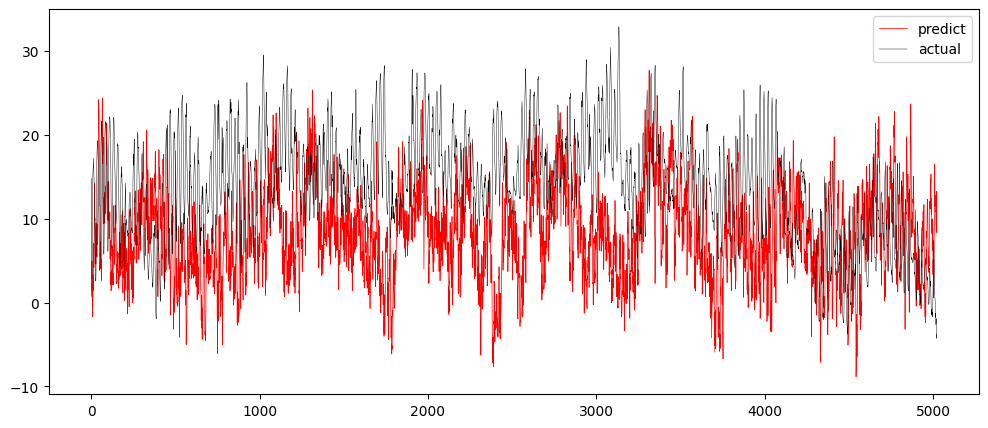

RMSE = 10.125911413921022 
MAE = 8.257948435406323 
MAPE = 5749109314657.358


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
plt.figure(figsize=(12, 5))
plt.plot(imf_lstm_fc, label='predict', color='r', linewidth=0.5)
plt.plot(test.values, label='actual', color='k', linewidth=0.3)
plt.legend()
plt.show()

RMSE_EEMD_LSTM = mean_squared_error(test, imf_lstm_fc, squared=False)
MAE_EEMD_LSTM = mean_absolute_error(test, imf_lstm_fc)
MAPE_EEMD_LSTM = mean_absolute_percentage_error(test, imf_lstm_fc)

print('RMSE = {}'.format(RMSE_EEMD_LSTM), 
      '\nMAE = {}'.format(MAE_EEMD_LSTM), 
      '\nMAPE = {}'.format(MAPE_EEMD_LSTM))

In [30]:
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error

# Definir función de minimización
def dummy1(c):
    global test
    global imf_lstm_fc
    return mean_absolute_error(test, imf_lstm_fc + c)

# Minimización
res = minimize(dummy1, 0, method='nelder-mead',
                 options={'xatol': 1e-8, 'disp': True})

print('Valor óptimo de c:', res.x)

Optimization terminated successfully.
         Current function value: 6.646651
         Iterations: 43
         Function evaluations: 86
Valor óptimo de c: [5.8745734]


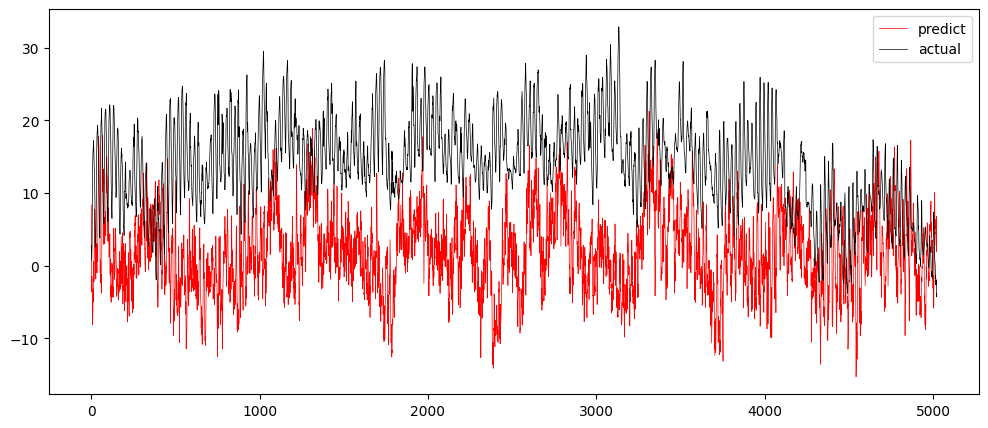

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(imf_lstm_fc + res.x[0], label='predict', color='r', linewidth=0.5)
plt.plot(test.values, label='actual', color='k', linewidth=0.5)
plt.legend()
plt.show()

RMSE_EEMD_LSTM = mean_squared_error(test, imf_lstm_fc + res.x[0], squared=False)
MAE_EEMD_LSTM = mean_absolute_error(test, imf_lstm_fc + res.x[0])
MAPE_EEMD_LSTM = mean_absolute_percentage_error(test, imf_lstm_fc + res.x[0])

In [27]:
print('RMSE = {}'.format(RMSE_EEMD_LSTM), 
      '\nMAE = {}'.format(MAE_EEMD_LSTM), 
      '\nMAPE = {}'.format(MAPE_EEMD_LSTM))

RMSE = 8.319870394652494 
MAE = 6.646650810548414 
MAPE = 11016225895591.729
